## Hand-written Digit Recognition using gluon

In [9]:
import mxnet as mx
import numpy as np

import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

# Select a fixed random seed for reproducibility
mx.random.seed(42)

def data_xform(data):
    """Move channel axis to the beginning, cast to float32, and normalize to [0, 1]."""
    return nd.moveaxis(data, 2, 0).astype('float32') / 255

train_data = mx.gluon.data.vision.MNIST(train=True).transform_first(data_xform)
val_data = mx.gluon.data.vision.MNIST(train=False).transform_first(data_xform)

In [15]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)


In [16]:
batch_size = 100
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = mx.gluon.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [22]:
conv_layer = nn.Conv2D(kernel_size=(3, 3), channels=32, in_channels=16, activation='relu')
print(conv_layer.params)

conv2_ (
  Parameter conv2_weight (shape=(32, 16, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv2_bias (shape=(32,), dtype=<class 'numpy.float32'>)
)


In [23]:
metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

In [24]:
lenet = nn.HybridSequential(prefix='LeNet_')
with lenet.name_scope():
    lenet.add(
        nn.Conv2D(channels=20, kernel_size=(5, 5), activation='tanh'),
        nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        nn.Conv2D(channels=50, kernel_size=(5, 5), activation='tanh'),
        nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        nn.Flatten(),
        nn.Dense(500, activation='tanh'),
        nn.Dense(10, activation=None),
    )

In [25]:
lenet.initialize(mx.init.Xavier(), ctx=ctx)
lenet.summary(nd.zeros((1, 1, 28, 28), ctx=ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1                <Symbol eNet_conv0_tanh_fwd>               0
        Activation-2                             (1, 20, 24, 24)               0
            Conv2D-3                             (1, 20, 24, 24)             520
         MaxPool2D-4                             (1, 20, 12, 12)               0
        Activation-5                <Symbol eNet_conv1_tanh_fwd>               0
        Activation-6                               (1, 50, 8, 8)               0
            Conv2D-7                               (1, 50, 8, 8)           25050
         MaxPool2D-8                               (1, 50, 4, 4)               0
           Flatten-9                                    (1, 800)               0
       Activation-10        

In [26]:
trainer = gluon.Trainer(
    params=lenet.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)
metric = mx.metric.Accuracy()
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = lenet(inputs)
            loss = loss_function(outputs, labels)

        loss.backward()
        metric.update(labels, outputs)

        trainer.step(batch_size=inputs.shape[0])

    name, acc = metric.get()
    print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
    metric.reset()

for inputs, labels in val_loader:
    inputs = inputs.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    metric.update(labels, lenet(inputs))
print('Validaton: {} = {}'.format(*metric.get()))
assert metric.get()[1] > 0.985

After epoch 1: accuracy = 0.8972666666666667
After epoch 2: accuracy = 0.9629333333333333
After epoch 3: accuracy = 0.9739
After epoch 4: accuracy = 0.97865
After epoch 5: accuracy = 0.98265
After epoch 6: accuracy = 0.9849166666666667
After epoch 7: accuracy = 0.9862333333333333
After epoch 8: accuracy = 0.9880666666666666
After epoch 9: accuracy = 0.9889333333333333
After epoch 10: accuracy = 0.9900666666666667
Validaton: accuracy = 0.9887


In [31]:
def get_mislabeled(loader):
    """Return list of ``(input, pred_lbl, true_lbl)`` for mislabeled samples."""
    mislabeled = []
    for inputs, labels in loader:
        inputs = inputs.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        outputs = lenet(inputs)
        # Predicted label is the index is where the output is maximal
        preds = nd.argmax(outputs, axis=1)
        for i, p, l in zip(inputs, preds, labels):
            p, l = int(p.asscalar()), int(l.asscalar())
            if p != l:
                mislabeled.append((i.asnumpy(), p, l))
    return mislabeled

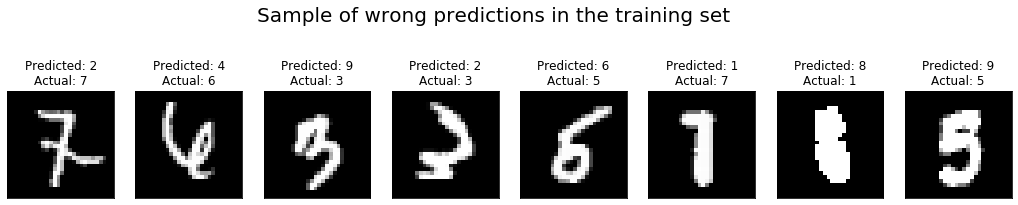

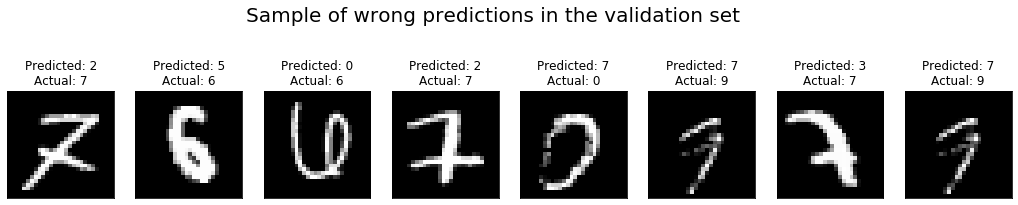

In [32]:
import numpy as np

sample_size = 8
wrong_train = get_mislabeled(train_loader)
wrong_val = get_mislabeled(val_loader)
wrong_train_sample = [wrong_train[i] for i in np.random.randint(0, len(wrong_train), size=sample_size)]
wrong_val_sample = [wrong_val[i] for i in np.random.randint(0, len(wrong_val), size=sample_size)]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=sample_size)
for ax, (img, pred, lbl) in zip(axs, wrong_train_sample):
    fig.set_size_inches(18, 4)
    fig.suptitle("Sample of wrong predictions in the training set", fontsize=20)
    ax.imshow(img[0], cmap="gray")
    ax.set_title("Predicted: {}\nActual: {}".format(pred, lbl))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

fig, axs = plt.subplots(ncols=sample_size)
for ax, (img, pred, lbl) in zip(axs, wrong_val_sample):
    fig.set_size_inches(18, 4)
    fig.suptitle("Sample of wrong predictions in the validation set", fontsize=20)
    ax.imshow(img[0], cmap="gray")
    ax.set_title("Predicted: {}\nActual: {}".format(pred, lbl))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)